In [1]:
#nltk.download("stopwords")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import operator
import re
import os
import gc
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import string
from copy import deepcopy

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from nltk import word_tokenize, ngrams
from sklearn.cross_validation import KFold
from sklearn import ensemble
from sklearn.metrics import log_loss

import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
pal = sns.color_palette()
color = sns.color_palette()
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None  # default='warn'

words = re.compile(r"\w+",re.I)
stopword = stopwords.words('english')

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(check_output(["ls", "C:/Documents/Quora_Question_pairs"]).decode("utf8"))

train = pd.read_csv("train.csv").fillna("")

test = pd.read_csv("test.csv").fillna("")

Quora_Question_pair.3gpp
Quora_Question_pairs.rar
final version-02.ipynb
sample_submission.csv
test.csv
train.csv



In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
test.head()

,id,qid1,qid2,question1,question2
0,49999,88910,88911,Why can some people hold their liquor so much better than others?,How do you make malt liquor taste better?
1,50000,88912,88913,Why is human cloning considered unethical?,Why is cloning considered unethical?
2,50001,88914,88915,What is Quora's monetization strategy?,Adam D'Angelo: What is Quora's monetization strategy?
3,50002,88916,88917,Is the Moto G4 Plus waterproof?,Should i buy a Moto G4 plus?
4,50003,88918,32373,Where can I get very nice and original flavor cupcakes in Gold Coast?,Where can I buy best quality gourmet cupcakes in Gold Coast?


In [5]:
print(train.shape)
print(test.shape)

(49999, 6)
(49999, 5)


In [6]:
print(train.isnull().sum())
print(test.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
id           0
qid1         0
qid2         0
question1    0
question2    0
dtype: int64


In [7]:
for i in range(6):
    print(train.question1[i])
    print(train.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?



In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 6 columns):
id              49999 non-null int64
qid1            49999 non-null int64
qid2            49999 non-null int64
question1       49999 non-null object
question2       49999 non-null object
is_duplicate    49999 non-null int64
dtypes: int64(4), object(2)
memory usage: 2.3+ MB


# Feature construction

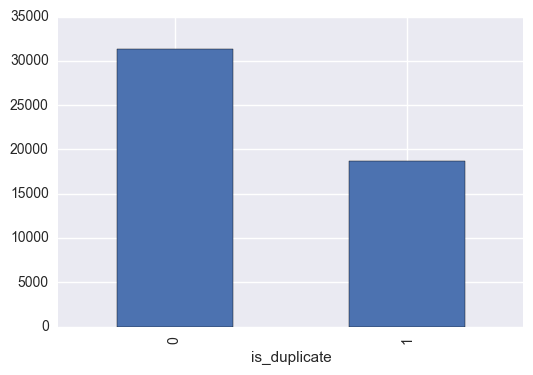

In [9]:
train.groupby("is_duplicate")['id'].count().plot.bar()

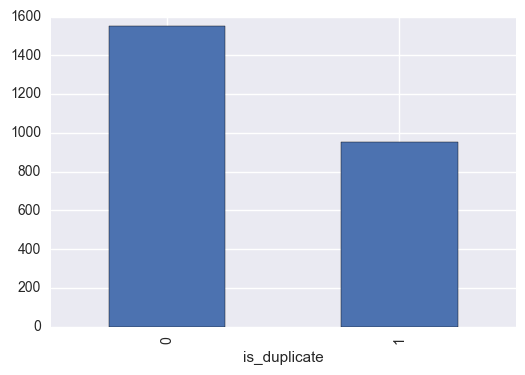

In [10]:
dfs = train[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

In [11]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

In [12]:
all_ques_df = pd.DataFrame(pd.concat([train['question1'], train['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

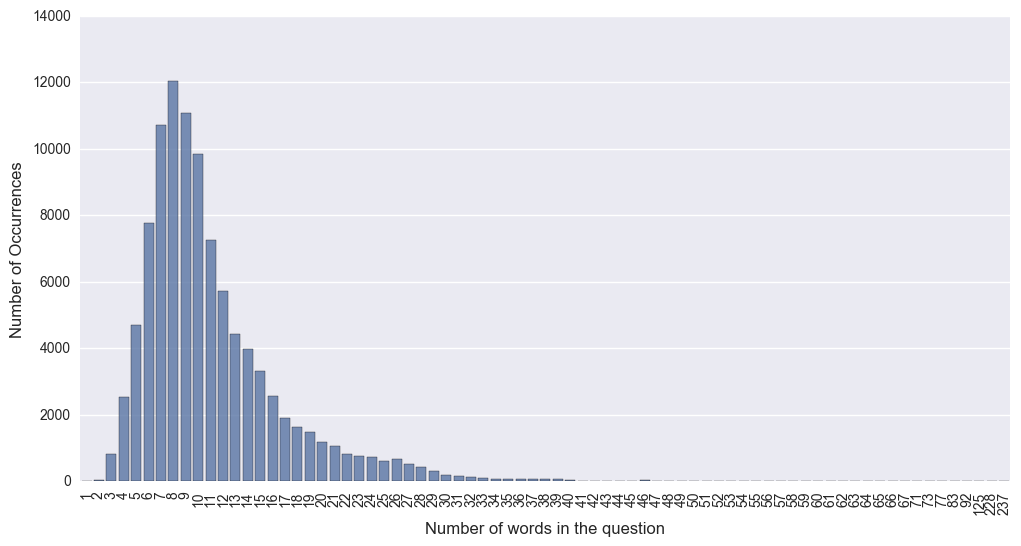

In [13]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Total number of question pairs for training: 49999
Duplicate pairs: 37.3%
Total number of questions in the training data: 88909
Number of questions that appear multiple times: 7396



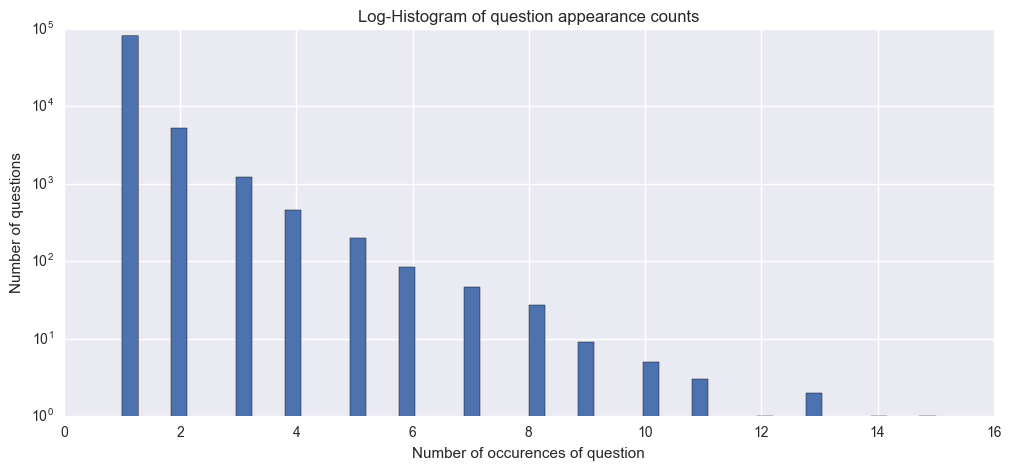

In [14]:
print('Total number of question pairs for training: {}'.format(len(train)))
print('Duplicate pairs: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

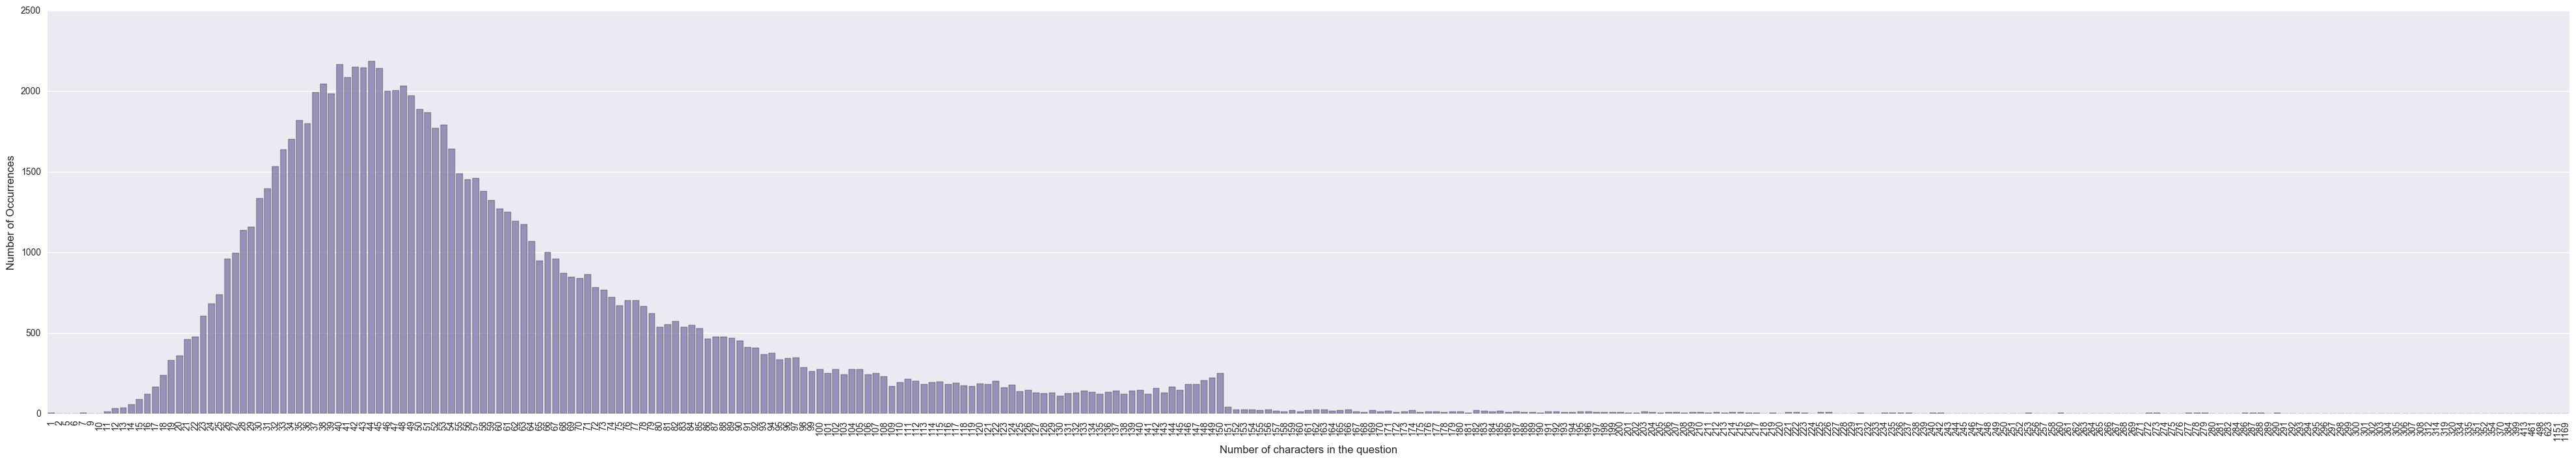

In [15]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
cnt_srs = all_ques_df['num_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()      

del all_ques_df

mean-train 59.77 std-train 32.07 mean-test 59.64 std-test 32.07 max-train 1169.00 max-test 1151.00


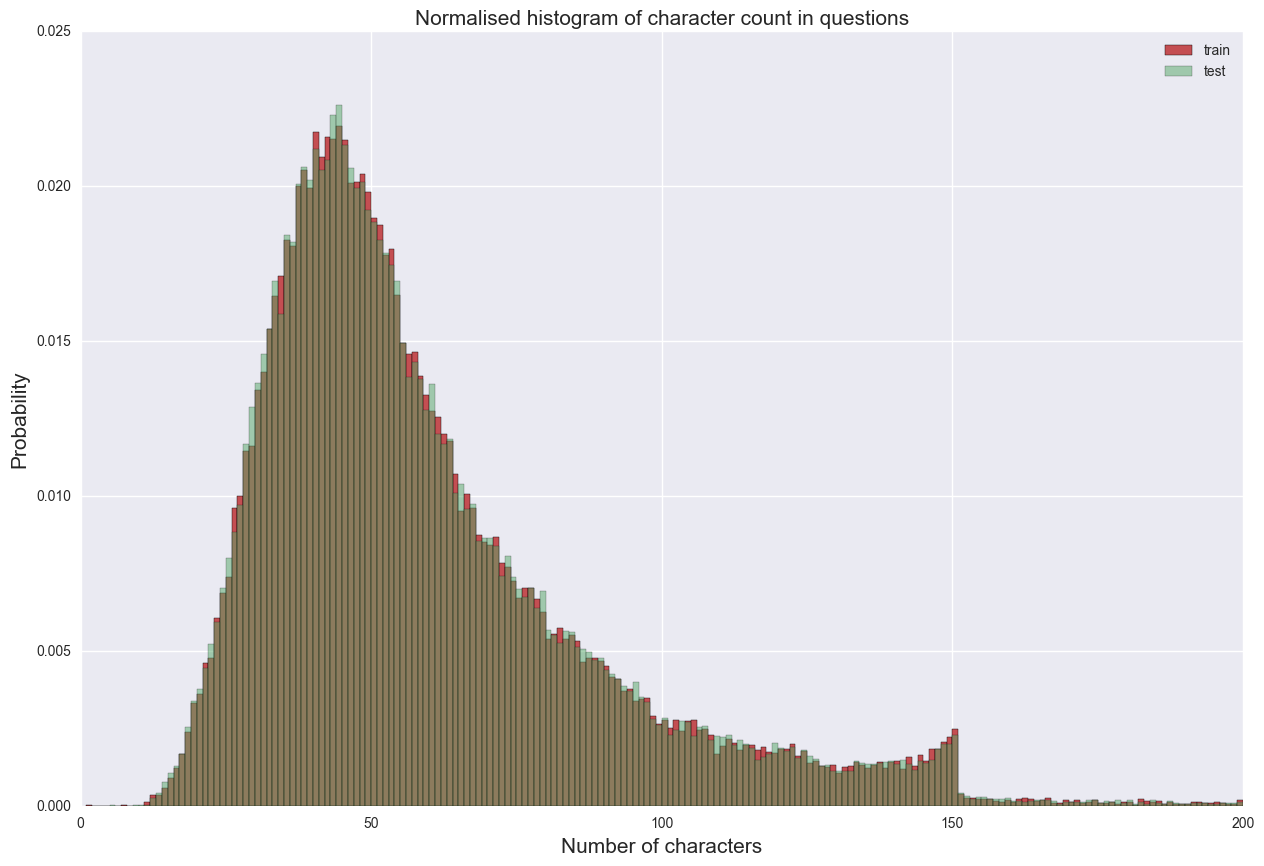

In [16]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.05 std-train 5.91 mean-test 11.05 std-test 5.94 max-train 237.00 max-test 237.00


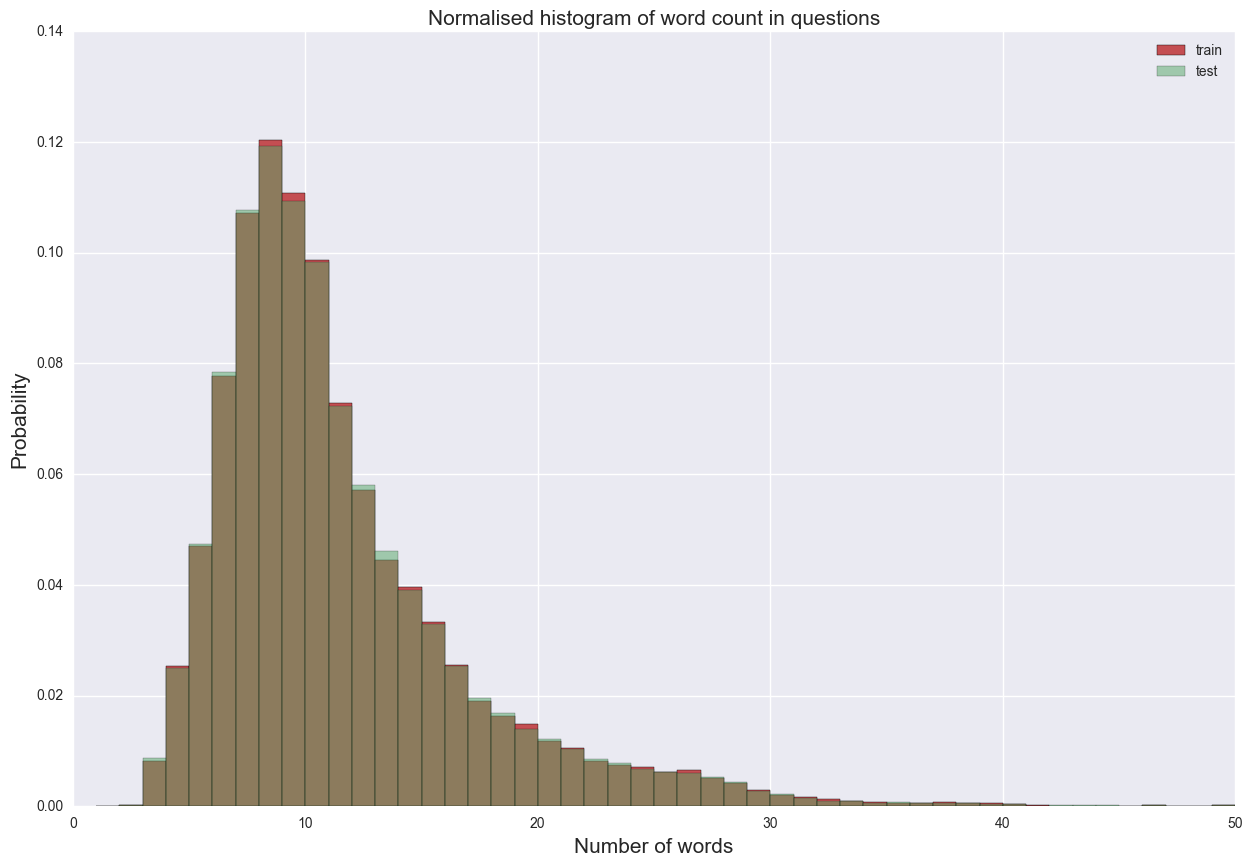

In [25]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

In [26]:
mq1 = TfidfVectorizer().fit_transform(dfqa['question'].values)
mq1

<5000x7003 sparse matrix of type '<class 'numpy.float64'>'
	with 50720 stored elements in Compressed Sparse Row format>

In [27]:
diff_encodings = mq1[::2] - mq1[1::2]
diff_encodings

<2500x7003 sparse matrix of type '<class 'numpy.float64'>'
	with 48610 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

In [28]:
#n = 10000
#sns.pairplot(train[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

In [29]:
import nltk
STOP_WORDS = nltk.corpus.stopwords.words()


In [34]:

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_&*)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_trainframe(df):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    df = df.dropna(how="any")
    
    for col in ['question1', 'question2']:
        df[col] = df[col].apply(clean_sentence)
    
    return df

df = clean_trainframe(train)
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor kohinoor diamond back,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane carbon oxide,fish would survive salt water,0


In [35]:
def build_corpus(df):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in df[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus


corpus = build_corpus(df)        
corpus[0:2]

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond']]

In [36]:

from gensim.models import word2vec
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['trump']

array([ 0.40676579,  1.32013083,  0.3273831 , -1.05515754,  0.7527566 ,
        0.66278845, -0.6146214 ,  0.17620763, -1.06170726, -0.86060762,
        0.60091239, -0.75015825,  0.69519943,  1.10455596,  0.88773882,
        1.0646528 , -0.3079702 ,  1.4127605 , -0.01787638,  0.4412156 ,
       -0.91616142,  0.82184213,  0.46285436,  0.82420766, -0.02024702,
        0.27141231,  0.38010952, -0.15085277, -0.35081756, -0.38727608,
        1.32392883, -0.36089966,  0.80053461, -0.35145557, -0.28738371,
        0.75284791,  0.2327548 ,  0.05231067,  0.38695952,  0.14415717,
       -0.76274419,  0.04498238, -0.63291478,  0.81208879, -0.04957856,
       -0.04686686,  0.77689689, -0.20188619, -0.39171091,  0.58425856,
        0.5779767 ,  0.25514868, -0.18191418,  0.64876026, -0.96672529,
        1.35115051, -0.01601995, -0.67368072, -0.59849197,  0.12520671,
       -0.09279006,  0.1765404 ,  0.3487922 ,  0.55821371, -0.22240481,
       -0.45320901,  0.94679707,  0.41789663,  0.27571529, -0.68

In [37]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

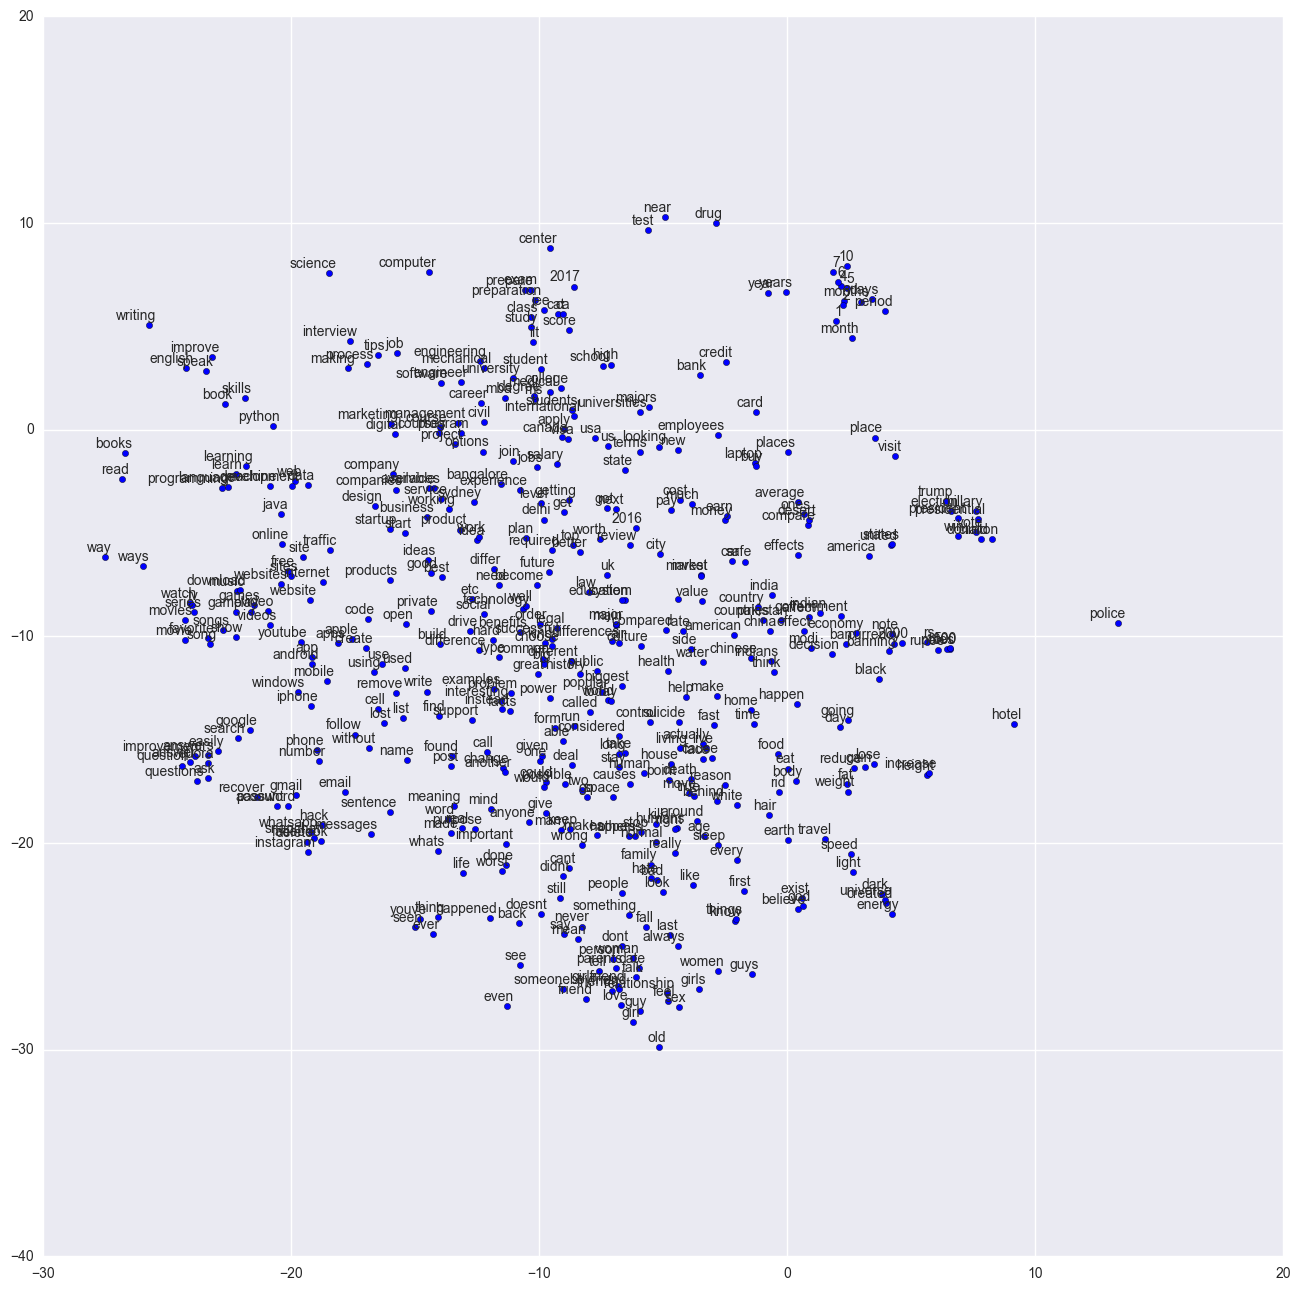

In [38]:
tsne_plot(model)

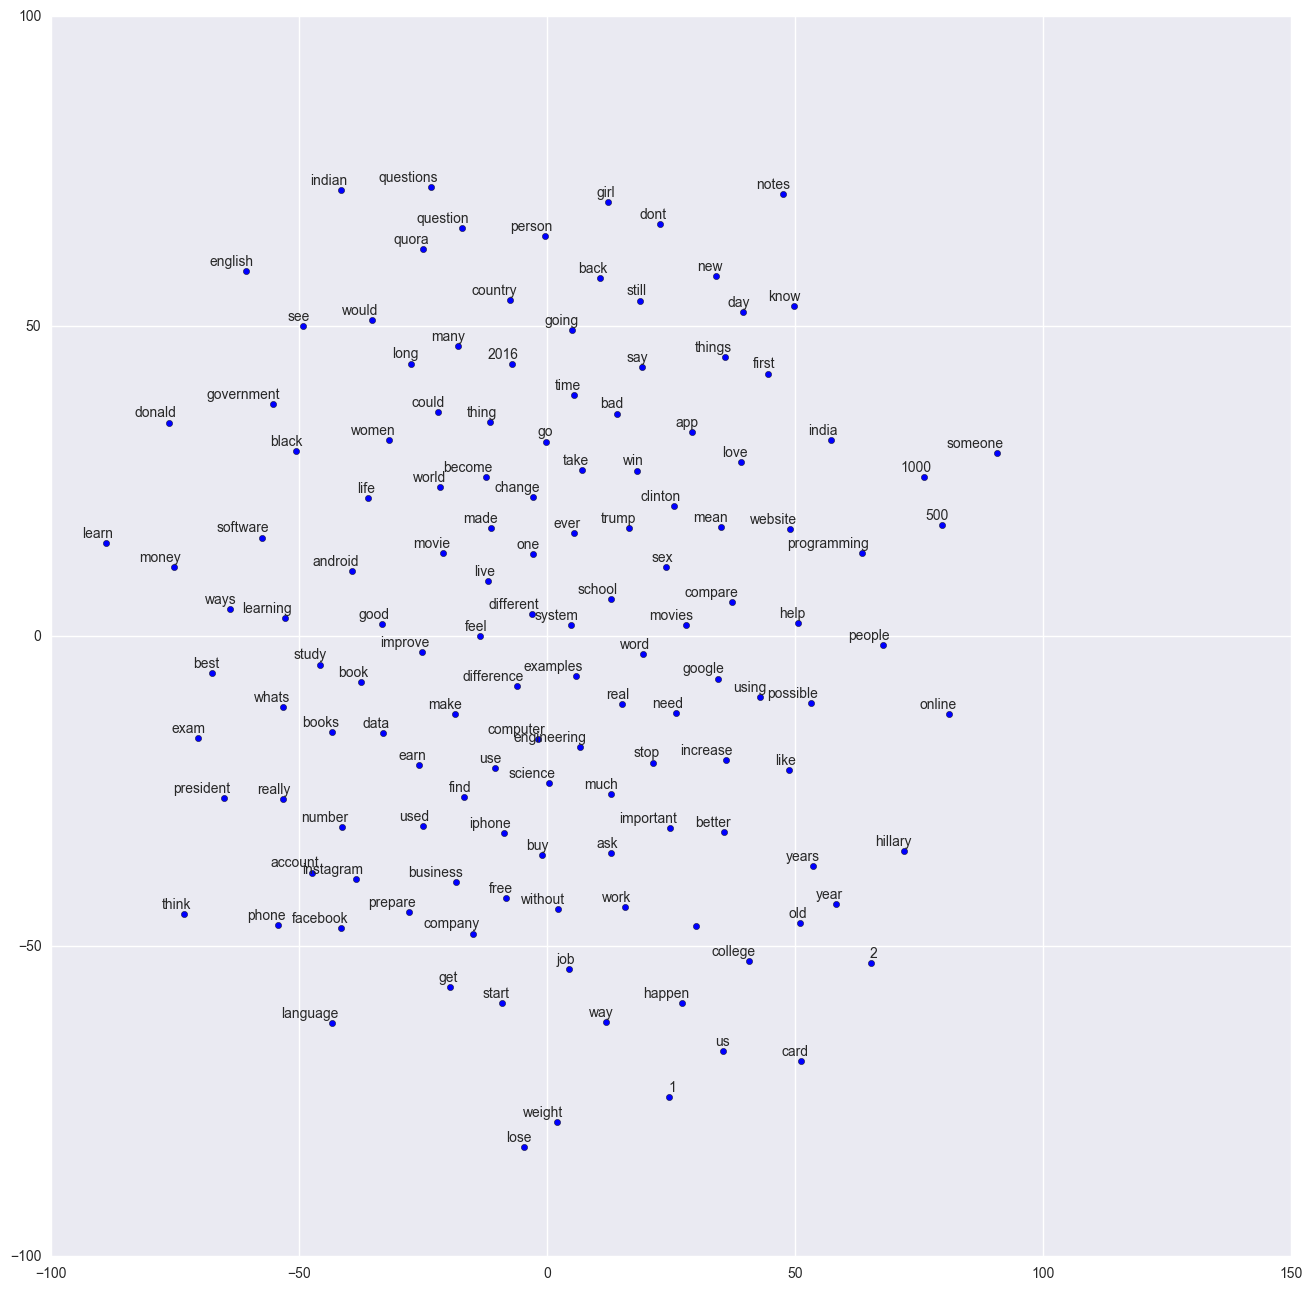

In [39]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

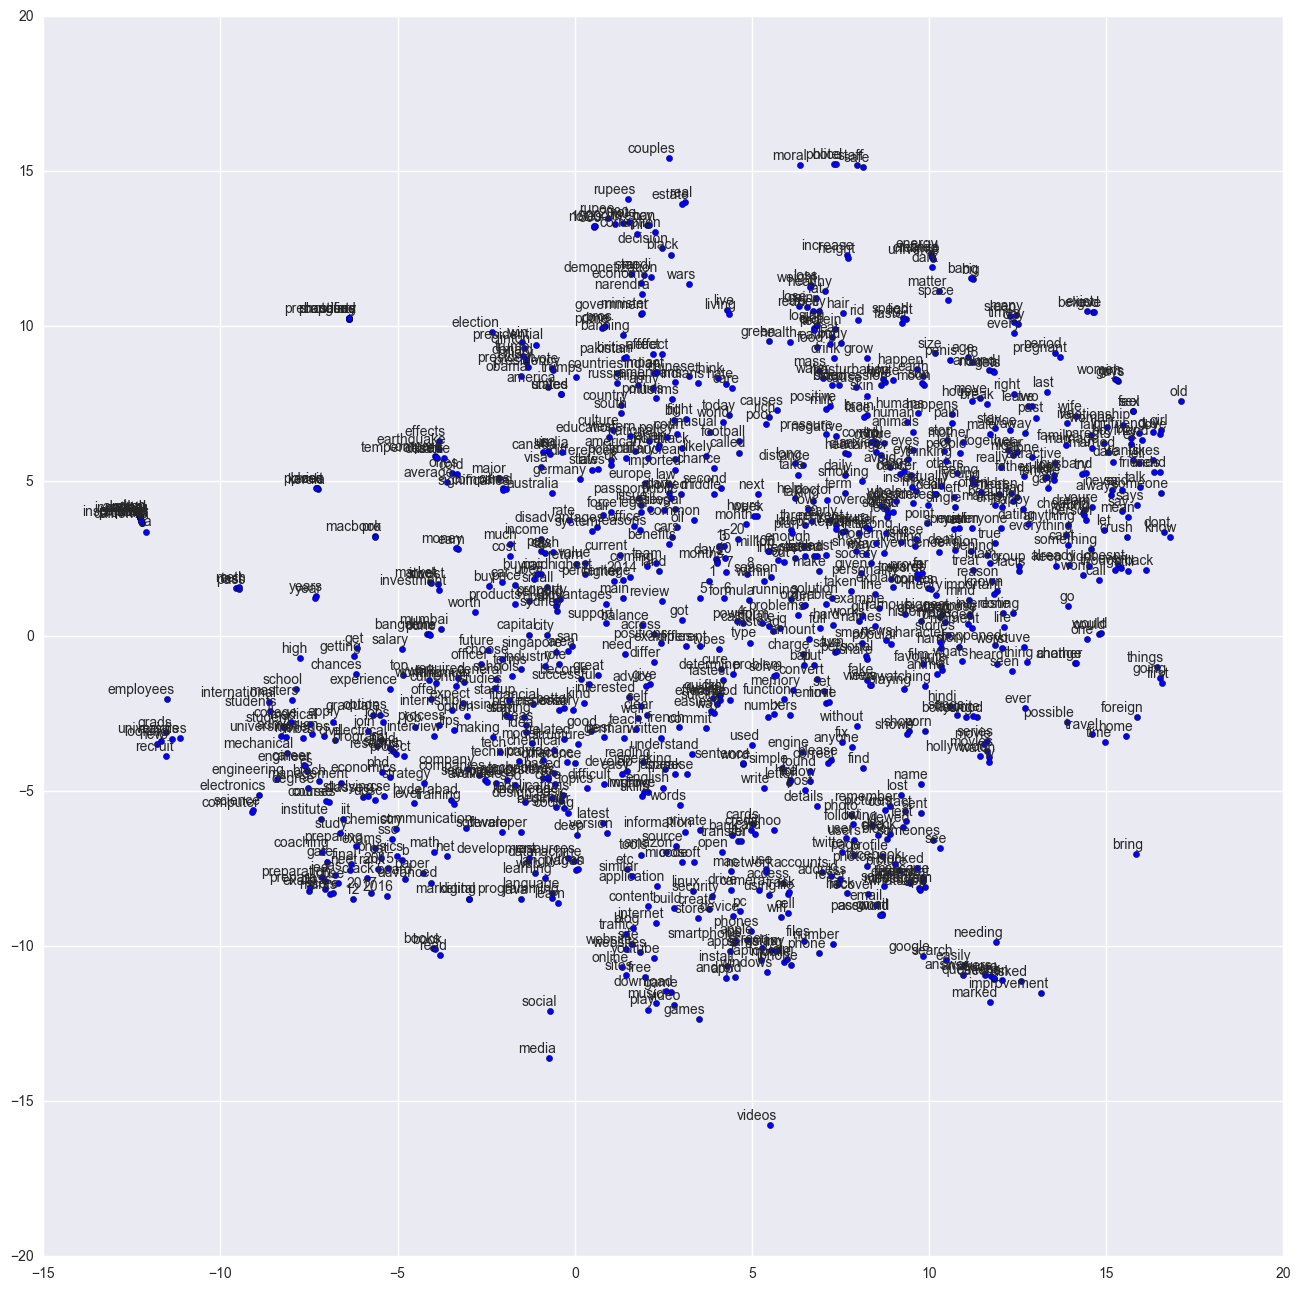

In [40]:
# A less selective model
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

In [31]:
model.most_similar('trump')

[('trumps', 0.8914628028869629),
 ('hillary', 0.8595828413963318),
 ('president', 0.8019616603851318),
 ('obama', 0.7949279546737671),
 ('election', 0.7702857255935669),
 ('vote', 0.7350043058395386),
 ('presidential', 0.7271516919136047),
 ('clinton', 0.7270306348800659),
 ('party', 0.7210707068443298),
 ('presidency', 0.7142395377159119)]

In [32]:
model.most_similar('universe')

[('created', 0.9451283812522888),
 ('infinite', 0.9166125059127808),
 ('dark', 0.9139938354492188),
 ('space', 0.910131573677063),
 ('matter', 0.8822559118270874),
 ('energy', 0.8529971241950989),
 ('point', 0.8255568742752075),
 ('evidence', 0.8167011141777039),
 ('bang', 0.8155608773231506),
 ('limit', 0.7991433143615723)]

In [42]:
from collections import Counter
import matplotlib.pyplot as plt
import operator

def eda(df):
    print ("Duplicate Count = %s , Non Duplicate Count = %s" 
           %(df.is_duplicate.value_counts()[1],df.is_duplicate.value_counts()[0]))
    
    question_ids_combined = df.qid1.tolist() + df.qid2.tolist()
    
    print ("Unique Questions = %s" %(len(np.unique(question_ids_combined))))
    
    question_ids_counter = Counter(question_ids_combined)
    sorted_question_ids_counter = sorted(question_ids_counter.items(), key=operator.itemgetter(1))
    question_appearing_more_than_once = [i for i in question_ids_counter.values() if i > 1]
    print ("Count of Quesitons appearing more than once = %s" %(len(question_appearing_more_than_once)))
    
    
eda(train)

Duplicate Count = 18649 , Non Duplicate Count = 31350
Unique Questions = 88909
Count of Quesitons appearing more than once = 7396


In [46]:
test.head()

,id,qid1,qid2,question1,question2
0,49999,88910,88911,Why can some people hold their liquor so much better than others?,How do you make malt liquor taste better?
1,50000,88912,88913,Why is human cloning considered unethical?,Why is cloning considered unethical?
2,50001,88914,88915,What is Quora's monetization strategy?,Adam D'Angelo: What is Quora's monetization strategy?
3,50002,88916,88917,Is the Moto G4 Plus waterproof?,Should i buy a Moto G4 plus?
4,50003,88918,32373,Where can I get very nice and original flavor cupcakes in Gold Coast?,Where can I buy best quality gourmet cupcakes in Gold Coast?


In [48]:
def eda(df):
    question_ids_combined = df.qid1.tolist() + df.qid2.tolist()
    
    print ("Unique Questions = %s" %(len(np.unique(question_ids_combined))))
    
    question_ids_counter = Counter(question_ids_combined)
    sorted_question_ids_counter = sorted(question_ids_counter.items(), key=operator.itemgetter(1))
    question_appearing_more_than_once = [i for i in question_ids_counter.values() if i > 1]
    print ("Count of Quesitons appearing more than once = %s" %(len(question_appearing_more_than_once)))
    

In [49]:
eda(test)

Unique Questions = 88931
Count of Quesitons appearing more than once = 7421


In [43]:
import re
import gensim
from gensim import corpora
from nltk.corpus import stopwords

words = re.compile(r"\w+",re.I)
stopword = stopwords.words('english')

def tokenize_questions(df):
    question_1_tokenized = []
    question_2_tokenized = []

    for q in df.question1.tolist():
        question_1_tokenized.append([i.lower() for i in words.findall(q) if i not in stopword])

    for q in df.question2.tolist():
        question_2_tokenized.append([i.lower() for i in words.findall(q) if i not in stopword])

    df["Question_1_tok"] = question_1_tokenized
    df["Question_2_tok"] = question_2_tokenized
    
    return df

def train_dictionary(df):
    
    questions_tokenized = df.Question_1_tok.tolist() + df.Question_2_tok.tolist()
    
    dictionary = corpora.Dictionary(questions_tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000000)
    dictionary.compactify()
    
    return dictionary
    
df_train = tokenize_questions(train)
dictionary = train_dictionary(df_train)

print ("No of words in the dictionary = %s" %len(dictionary.token2id))

No of words in the dictionary = 10459


In [44]:
def get_vectors(df, dictionary):
    
    question1_vec = [dictionary.doc2bow(text) for text in df.Question_1_tok.tolist()]
    question2_vec = [dictionary.doc2bow(text) for text in df.Question_2_tok.tolist()]
    
    question1_csc = gensim.matutils.corpus2csc(question1_vec, num_terms=len(dictionary.token2id))
    question2_csc = gensim.matutils.corpus2csc(question2_vec, num_terms=len(dictionary.token2id))
    
    return question1_csc.transpose(),question2_csc.transpose()


q1_csc, q2_csc = get_vectors(df_train, dictionary)

print (q1_csc.shape)
print (q2_csc.shape)

(49999, 10459)
(49999, 10459)


In [50]:

df_test = tokenize_questions(test)
dictionary = train_dictionary(df_test)
q1_csc, q2_csc = get_vectors(df_test, dictionary)

In [51]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def get_cosine_similarity(q1_csc, q2_csc):
    cosine_sim = []
    for i,j in zip(q1_csc, q2_csc):
        sim = cs(i,j)
        cosine_sim.append(sim[0][0])
    
    return cosine_sim
    
cosine_sim = get_cosine_similarity(q1_csc, q2_csc)

print (len(cosine_sim))

49999


In [52]:
cosine_sim

[0.33806170189140661,
 0.86602540378443882,
 0.7559289460184544,
 0.59999999999999998,
 0.55555555555555558,
 0.46291004988627571,
 0.40201512610368484,
 0.79056941504209477,
 0.67612340378281321,
 0.42008402520840293,
 0.39999999999999997,
 0.50000000000000011,
 0.40406101782088427,
 1.0,
 0.77151674981045959,
 0.65197613936199839,
 0.25,
 0.99999999999999989,
 0.38138503569823695,
 0.67612340378281321,
 0.5103103630798288,
 0.0,
 1.0,
 0.72524066762284212,
 0.89442719099991586,
 0.69337524528153649,
 0.36514837167011083,
 0.77151674981045959,
 0.59999999999999998,
 0.47434164902525683,
 0.33806170189140661,
 0.0,
 0.20203050891044214,
 0.25819888974716115,
 0.79056941504209477,
 0.15811388300841894,
 0.46291004988627571,
 0.1690308509457033,
 0.81649658092772615,
 0.0,
 0.59999999999999998,
 0.61721339984836765,
 0.10540925533894598,
 0.7745966692414834,
 0.40089186286863654,
 0.0,
 0.88388347648318433,
 0.71713716560063612,
 0.51639777949432231,
 0.99999999999999989,
 0.721687836487

In [ ]:
 X_train,  =X.traiin
    X_test, =X.test
    y_train= y.train
    y_test 
    
   

In [37]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

np.random.seed(10)

def train_rfc(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
    
    svm_models = [('svm', SVC(verbose=1, shrinking=False))]
    svm_pipeline = Pipeline(svm_models)
    svm_params = {'svm__kernel' : ['rbf'],
                  'svm__C' : [0.01,0.1,1],
                  'svm__gamma' :[0.1,0.2,0.4],
                  'svm__tol' :[0.001,0.01,0.1],
                  'svm__class_weight' : [{1:0.8,0:0.2}]}

    rfc_models = [('rfc', RFC())]
    rfc_pipeline = Pipeline(rfc_models)
    rfc_params = {'rfc__n_estimators' : [40],
                  'rfc__max_depth' : [40],
                  'rfc__min_samples_leaf' : [50]}

    lr_models = [('lr', LR(verbose=1))]
    lr_pipeline = Pipeline(lr_models)
    lr_params = {'lr__C': [0.1, 0.01],
                 'lr__tol': [0.001,0.01],
                 'lr__max_iter': [200,400],
                 'lr__class_weight' : [{1:0.8,0:0.2}]}

    gbc_models = [('gbc', GBC(verbose=1))]
    gbc_pipeline = Pipeline(gbc_models)
    gbc_params = {'gbc__n_estimators' : [100,200, 400, 800],
                  'gbc__max_depth' : [40, 80, 160, 320],
                  'gbc__learning_rate' : [0.01,0.1]}

    grid = zip([svm_pipeline, rfc_pipeline, lr_pipeline, gbc_pipeline],
               [svm_params, rfc_params, lr_params, gbc_params])

    grid = zip([rfc_pipeline],
               [rfc_params])

    best_clf = None

    for model_pipeline, param in grid:
        temp = GridSearchCV(model_pipeline, param_grid=param, cv=4, scoring='f1')
        temp.fit(X_train, y_train)

        if best_clf is None:
            best_clf = temp
        else:
            if temp.best_score_ > best_clf.best_score_:
                best_clf = temp
    
    model_details = {}
    model_details["CV Accuracy"] = best_clf.best_score_
    model_details["Model Parameters"] = best_clf.best_params_
    model_details["Test Data Score"] = best_clf.score(X_test, y_test)
    model_details["F1 score"] = f1_score(y_test, best_clf.predict(X_test))
    model_details["Confusion Matrix"] = str(confusion_matrix(y_test, best_clf.predict(X_test)))
    
    return best_clf, model_details

X = np.array(cosine_sim).reshape(-1,1)
y = df_train.is_duplicate

clf, model_details = train_rfc(X,y)

print (model_details)

{'CV Accuracy': 0.57755777461483471, 'F1 score': 0.57219251336898402, 'Test Data Score': 0.57219251336898402, 'Confusion Matrix': '[[2330  858]\n [ 742 1070]]', 'Model Parameters': {'rfc__n_estimators': 40, 'rfc__min_samples_leaf': 50, 'rfc__max_depth': 40}}


C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:418: ChangedBehaviorWarning:

The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.

